In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")  # Suprime avisos

In [57]:
def plot_unfiltered(path,name, color,ax):
    # Carrega o CSV; substitua 'seuarquivo.csv' pelo caminho do seu arquivo
    df = pd.read_csv(path, parse_dates=['Post Timestamp', 'Reply Timestamp'])

    df = df[(df['Post Timestamp'] >= '2023-09-01') & (df['Post Timestamp'] <= '2025-01-01')]


    unique_posts = df.drop_duplicates(subset=['Post Text', 'Post Timestamp', 'Post Link'])

    # Gera uma nova coluna com o início do mês para cada post
    unique_posts['Start of Month'] = unique_posts['Post Timestamp'].dt.to_period('M').apply(lambda r: r.start_time)

    # Conta quantos posts únicos por mês
    monthly_counts = unique_posts.groupby('Start of Month').size()

    # Cria o line plot
    ax.plot(monthly_counts.index, monthly_counts.values,label = name,color = color)
    return None


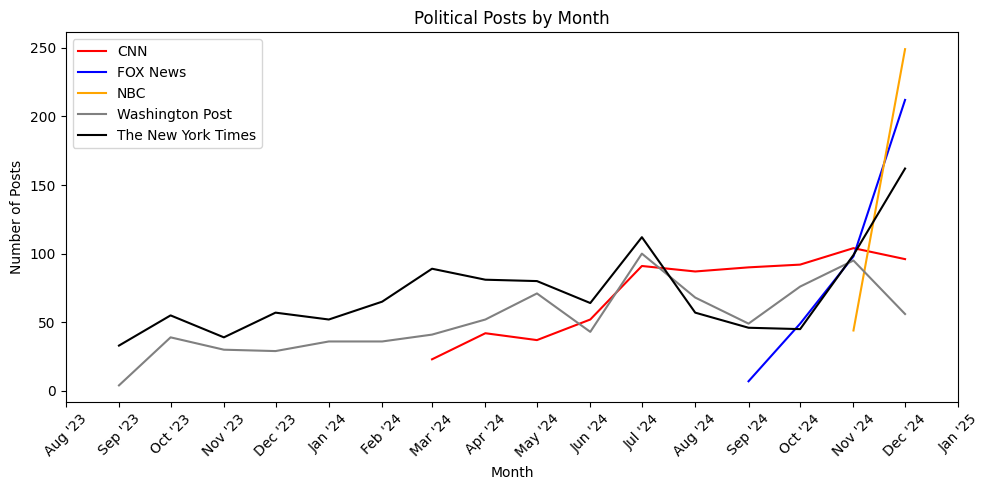

In [58]:

fig, ax = plt.subplots(figsize=(10,5))

plot_unfiltered("politics_posts_and_replies_CNN.csv", "CNN","red",ax)
plot_unfiltered("politics_posts_and_replies_FOX.csv", "FOX News","blue",ax)
plot_unfiltered("politics_posts_and_replies_NBC.csv", "NBC","orange",ax)
plot_unfiltered("politics_posts_and_replies_TWP.csv", "Washington Post","gray",ax)
plot_unfiltered("politics_posts_and_replies_TNYT.csv", "The New York Times","black",ax)





ax.set_title('Political Posts by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Posts')

all_months = pd.date_range(start='2023-08-01', end="2025-01-01", freq='MS')

ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)


plt.legend(loc= "best")

plt.tight_layout()
plt.show()

In [47]:
def plot_overall_keyword_percentage_weekly_smoothed(paths, keyword, color, ax, window=4):
    all_frames = []
    # Loop por cada arquivo para ler, filtrar e preparar os dados
    for path in paths:
        df = pd.read_csv(path, parse_dates=['Post Timestamp', 'Reply Timestamp'])
        df = df[(df['Post Timestamp'] >= '2023-09-01') & (df['Post Timestamp'] <= '2025-01-01')]
        
        # Se for o dataset da FOX, substitui texto vazio pelo link
        if "FOX" in path:
            # Verifica onde 'Post Text' está vazio ou nulo e substitui pelo 'Post Link'
            df['Post Text'] = df["Post Link"].copy()
        
        # Remove duplicatas baseadas no post
        unique_posts = df.drop_duplicates(subset=['Post Text', 'Post Timestamp', 'Post Link'])
        unique_posts['Start of Week'] = unique_posts['Post Timestamp']\
                                        .dt.to_period('W')\
                                        .apply(lambda r: r.start_time)
        all_frames.append(unique_posts)

    # Combina dados de todos os datasets
    combined = pd.concat(all_frames, ignore_index=True)

    # Conta total de posts por semana
    total_weekly = combined.groupby('Start of Week').size()

    # Filtra posts que contêm a palavra-chave (case-insensitive)
    keyword_posts = combined[combined['Post Text'].str.contains(keyword, case=False, na=False)]
    keyword_weekly = keyword_posts.groupby('Start of Week').size()

    # Cria uma sequência de semanas completas no intervalo para reindexar
    all_weeks = pd.date_range(start='2023-09-01', end='2025-01-01', freq='W-MON')
    total_weekly = total_weekly.reindex(all_weeks, fill_value=0)
    keyword_weekly = keyword_weekly.reindex(all_weeks, fill_value=0)

    # Calcula a porcentagem semanal
    percentage = (keyword_weekly / total_weekly.replace(0, pd.NA)) * 100
    percentage = percentage.fillna(0)

    # Aplica suavização com média móvel
    smoothed = percentage.rolling(window=window, min_periods=1, center=True).mean()

    # Plota a linha suavizada
    ax.plot(smoothed.index, smoothed.values, label=f"{keyword}", color=color)


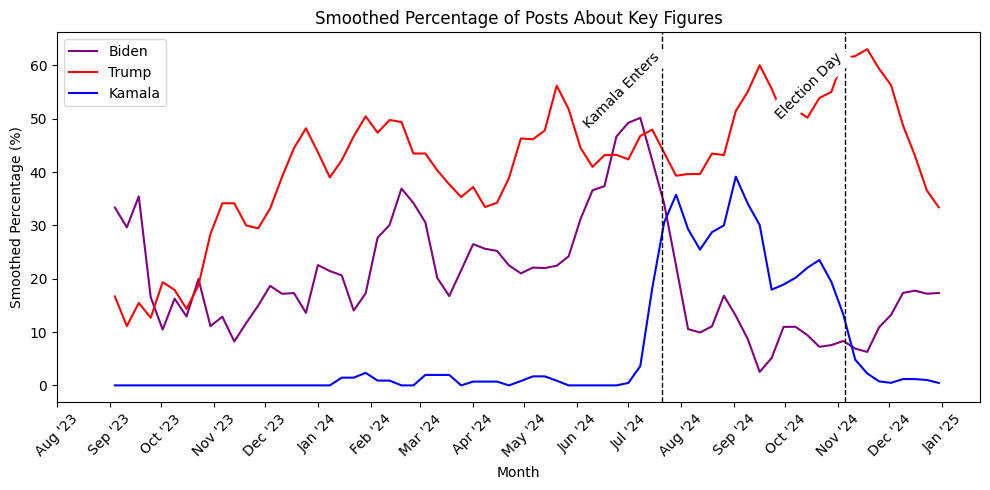

In [55]:
# Lista de caminhos para seus datasets
paths = [
    "politics_posts_and_replies_CNN.csv",
    "politics_posts_and_replies_FOX.csv",
    "politics_posts_and_replies_NBC.csv",
    "politics_posts_and_replies_TWP.csv",
    "politics_posts_and_replies_TNYT.csv"
]

fig, ax = plt.subplots(figsize=(10,5))
w = 3
# Plota a porcentagem agregada suavizada semanalmente
plot_overall_keyword_percentage_weekly_smoothed(paths, "Biden", "purple", ax,window=w)
plot_overall_keyword_percentage_weekly_smoothed(paths, "Trump", "red", ax,window=w)
plot_overall_keyword_percentage_weekly_smoothed(paths, "Kamala", "blue", ax, window=w)


ax.set_title('Smoothed Percentage of Posts About Key Figures')
ax.set_xlabel('Month')
ax.set_ylabel('Smoothed Percentage (%)')


event_dates = {
    "Kamala Enters": "2024-07-21",
    "Election Day": "2024-11-05"
}

ymax = ax.get_ylim()[1]

for event, date_str in event_dates.items():
    event_date = pd.Timestamp(date_str)
    ax.axvline(event_date, color='black', linestyle='--', linewidth=1)
    ax.text(event_date, ymax * 0.95, event,
            rotation=45,
            verticalalignment='top',
            horizontalalignment='right',
            backgroundcolor='white')

# Define ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [100]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Baixa o léxico VADER na primeira vez
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

texts = [
    "I love this product!",
    "Shit",
    "The event was okay, nothing special."
]

for text in texts:
    scores = sia.polarity_scores(text)
    print(f"Texto: {text}")
    print(f"Pontuações de Sentimento: {scores}\n")


Texto: I love this product!
Pontuações de Sentimento: {'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'compound': 0.6696}

Texto: Shit
Pontuações de Sentimento: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5574}

Texto: The event was okay, nothing special.
Pontuações de Sentimento: {'neg': 0.277, 'neu': 0.49, 'pos': 0.233, 'compound': -0.092}



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [71]:
def plot_average_reply_sentiment_weekly_keyword(paths, keyword, color, ax, window=4, lab = None):

    if lab == None:
        lab = keyword
    analyzer = SentimentIntensityAnalyzer()
    all_frames = []
    
    for path in paths:
        # Ler CSV e garantir que 'Reply Timestamp' é datetime
        df = pd.read_csv(path, parse_dates=['Reply Timestamp', 'Post Timestamp'])
        
        # Converter explicitamente para datetime e descartar linhas sem data válida
        df['Reply Timestamp'] = pd.to_datetime(df['Reply Timestamp'], errors='coerce')
        df = df.dropna(subset=['Reply Timestamp'])
        
        # Filtrar pelo intervalo de datas baseado em 'Reply Timestamp'
        df = df[(df['Reply Timestamp'] >= '2023-09-01') & (df['Reply Timestamp'] <= '2025-01-01')]
        
        # Se for dataset da FOX, substituir texto vazio pelo link
        if "FOX" in path:
            df['Post Text'] = df["Post Link"]
        
        # Filtrar linhas onde o post contém a palavra-chave (case-insensitive)
        keyword_mask = df['Post Text'].str.contains(keyword, case=False, na=False)
        df = df[keyword_mask]
        
        # Se não houver dados após filtrar, pular este arquivo
        if df.empty:
            continue

        # Calcular o sentimento composto de cada reply
        df['reply_compound'] = df['Reply Text'].apply(
            lambda text: analyzer.polarity_scores(text)['compound'] if pd.notnull(text) else None
        )
        df = df.dropna(subset=['reply_compound'])
        
        # Criar coluna com o início da semana baseado em 'Reply Timestamp'
        df['Start of Week'] = df['Reply Timestamp'].dt.to_period('W').apply(lambda r: r.start_time)
        
        # Selecionar apenas as colunas necessárias para análise
        all_frames.append(df[['Start of Week', 'reply_compound']])
    
    # Verifica se há dados coletados
    if not all_frames:
        print("Nenhum dado disponível após filtragem.")
        return
    
    # Combinar dados de todos os arquivos
    combined = pd.concat(all_frames, ignore_index=True)
    
    # Calcular a média semanal do sentimento composto
    weekly_avg = combined.groupby('Start of Week')['reply_compound'].mean()
    
    # Aplicar média móvel para suavização
    smoothed = weekly_avg.rolling(window=window, min_periods=1, center=True).mean()
    
    # Plotar a série suavizada
    ax.plot(smoothed.index, smoothed.values, label=f"{lab}", color=color)

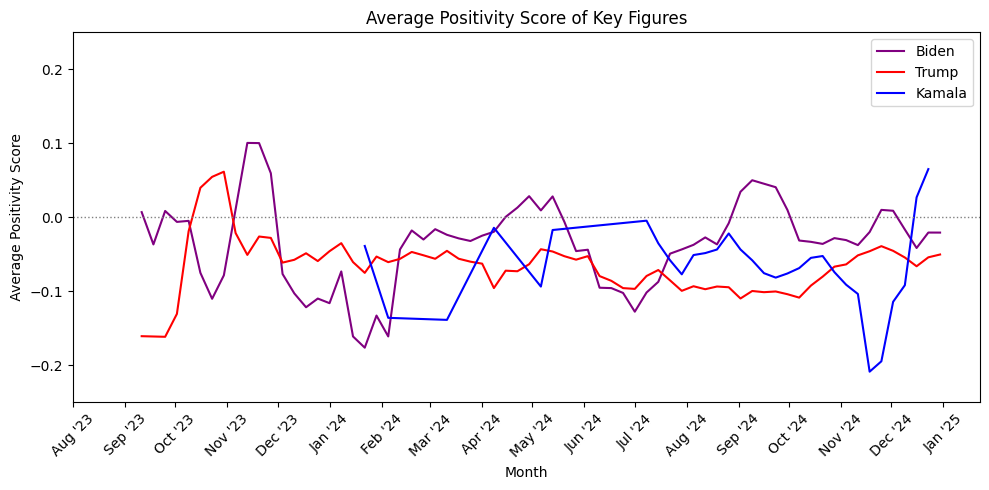

In [70]:
# Lista de caminhos para seus arquivos CSV
paths = [
    "politics_posts_and_replies_CNN.csv",
    "politics_posts_and_replies_FOX.csv",
    "politics_posts_and_replies_NBC.csv",
    "politics_posts_and_replies_TWP.csv",
    "politics_posts_and_replies_TNYT.csv"
]

fig, ax = plt.subplots(figsize=(10,5))

# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(paths, "Biden", "purple", ax)
plot_average_reply_sentiment_weekly_keyword(paths, "Trump", "red", ax)
plot_average_reply_sentiment_weekly_keyword(paths, "Kamala", "blue", ax)

ax.set_title('Average Positivity Score of Key Figures')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.25, 0.25)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


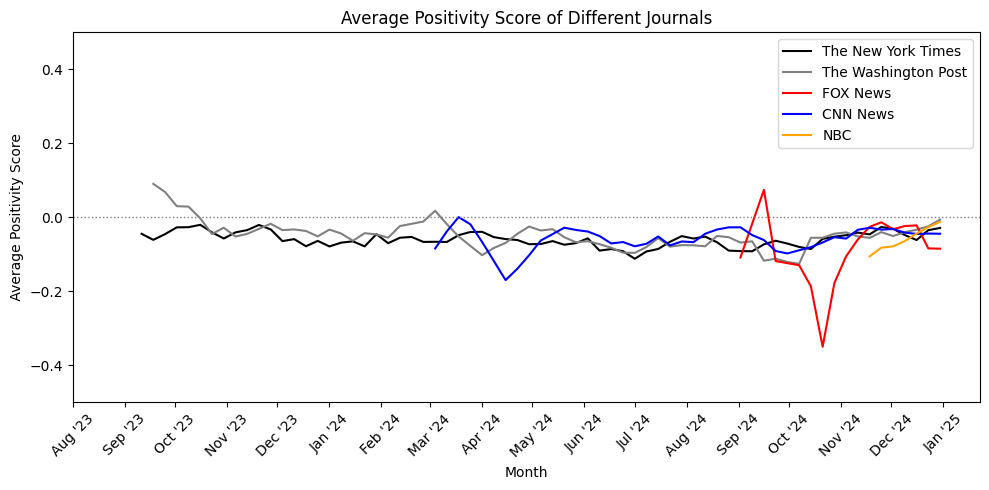

In [81]:
# Lista de caminhos para seus arquivos CSV
paths = ["politics_posts_and_replies_TNYT.csv"]

fig, ax = plt.subplots(figsize=(10,5))

# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], "", "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], "", "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], "", "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], "", "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], "", "orange", ax, lab="NBC")





ax.set_title('Average Positivity Score of Different Journals')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


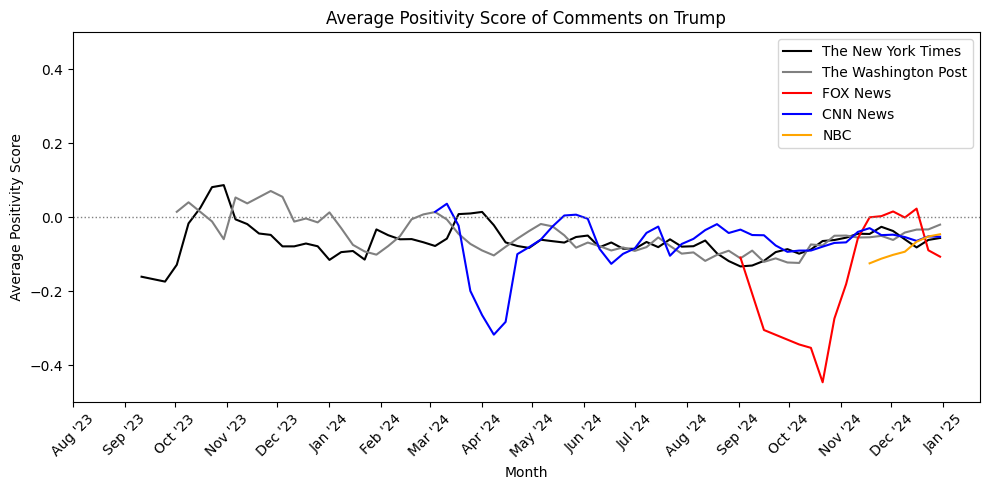

In [82]:
# Lista de caminhos para seus arquivos CSV
paths = ["politics_posts_and_replies_TNYT.csv"]

fig, ax = plt.subplots(figsize=(10,5))


keyword = "Trump"
# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], keyword, "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], keyword, "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], keyword, "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], keyword, "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], keyword, "orange", ax, lab="NBC")





ax.set_title(f'Average Positivity Score of Comments on {keyword}')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


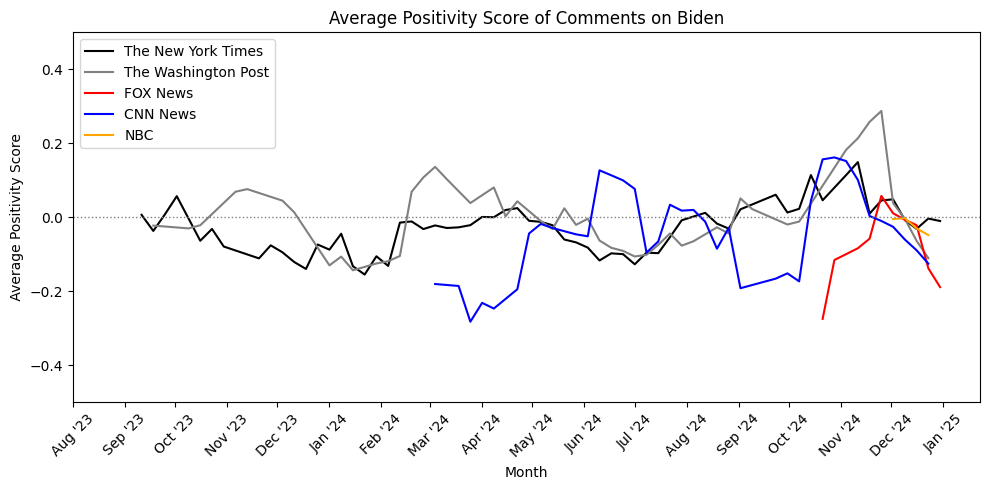

In [83]:
# Lista de caminhos para seus arquivos CSV

fig, ax = plt.subplots(figsize=(10,5))


keyword = "Biden"
# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], keyword, "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], keyword, "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], keyword, "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], keyword, "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], keyword, "orange", ax, lab="NBC")





ax.set_title(f'Average Positivity Score of Comments on {keyword}')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


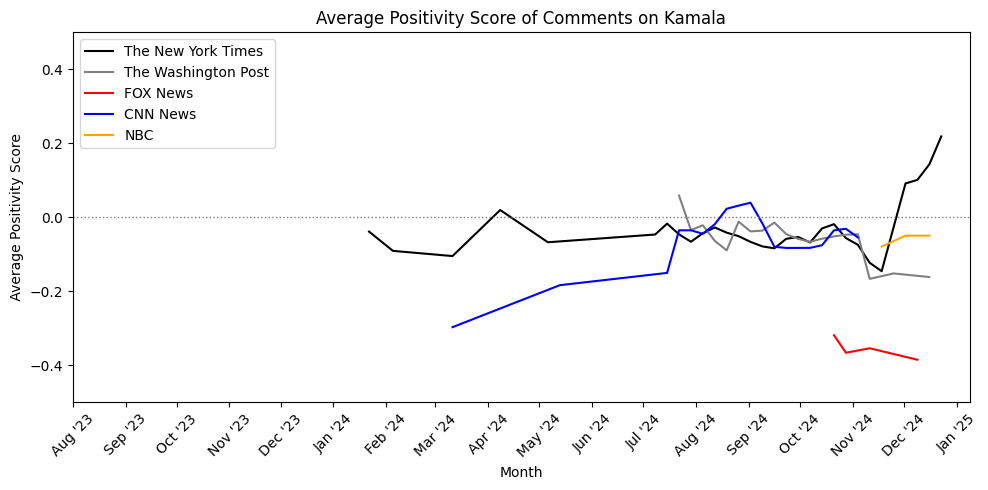

In [84]:
# Lista de caminhos para seus arquivos CSV

fig, ax = plt.subplots(figsize=(10,5))


keyword = "Kamala"
# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], keyword, "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], keyword, "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], keyword, "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], keyword, "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], keyword, "orange", ax, lab="NBC")





ax.set_title(f'Average Positivity Score of Comments on {keyword}')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


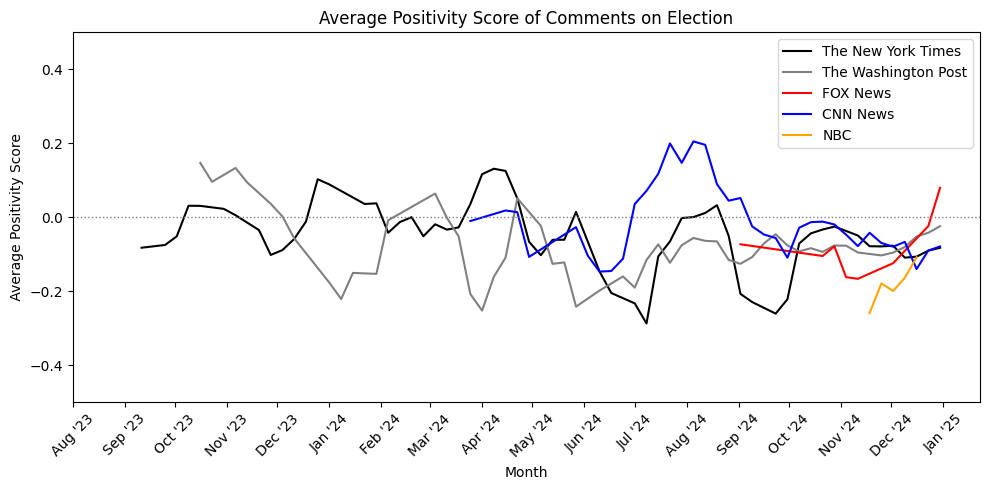

In [87]:
# Lista de caminhos para seus arquivos CSV
paths = ["politics_posts_and_replies_TNYT.csv"]

fig, ax = plt.subplots(figsize=(10,5))


keyword = "Election"
# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], keyword, "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], keyword, "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], keyword, "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], keyword, "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], keyword, "orange", ax, lab="NBC")





ax.set_title(f'Average Positivity Score of Comments on {keyword}')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()
